# SDSC3006 Group Project


## Steel Plates Faults Dataset (27 attributes, 1941 instances)


### Loading library


In [1]:
suppressPackageStartupMessages({
    library(repr)
    library(ggplot2)
    library(cowplot)
    library(reshape2)
    library(pROC)
    library(caret)
    library(class)
    library(e1071)
    library(gbm)
})


### Supporting functions


In [2]:
setPlotSize <- function(wRatio, hRatio) {
    options(repr.plot.width = wRatio * repr_option_defaults$repr.plot.width)
    options(repr.plot.height = hRatio * repr_option_defaults$repr.plot.height)
}


In [3]:
plotCM2Heatmap <- function(table) {
    ggplot(data = melt(table), aes(x = Prediction, y = Reference, fill = value)) +
        geom_tile(color = "black") +
        geom_text(aes(label = value)) +
        scale_fill_gradientn(colours = heat.colors(100, rev = TRUE)) +
        coord_fixed() +
        theme_grey(base_size = 14) +
        theme(axis.text.x = element_text(angle = 315, hjust = 0))
}


In [4]:
plotMultiRoc <- function(prediction, predictor, arrow) {
    set.seed(0)
    auc <- multiclass.roc(prediction, predictor, direction = arrow)
    for (i in 1:length(auc$rocs)) {
        plot.roc(auc$rocs[[i]], add = (if (i == 1) F else T), legacy.axes = T, lwd = 2, col = sample.int(100))
    }
}


### Set random seed


In [5]:
seed <- 0
print(seed)


[1] 0


### Load dataset


In [6]:
df <- read.table("Faults.NNA", col.names = as.vector(read.table("Faults27x7_var")$V1))
df.X <- scale(df[1:27])
df.Y <- data.frame(Faults = factor(names(df[28:34])[max.col(df[28:34])]))


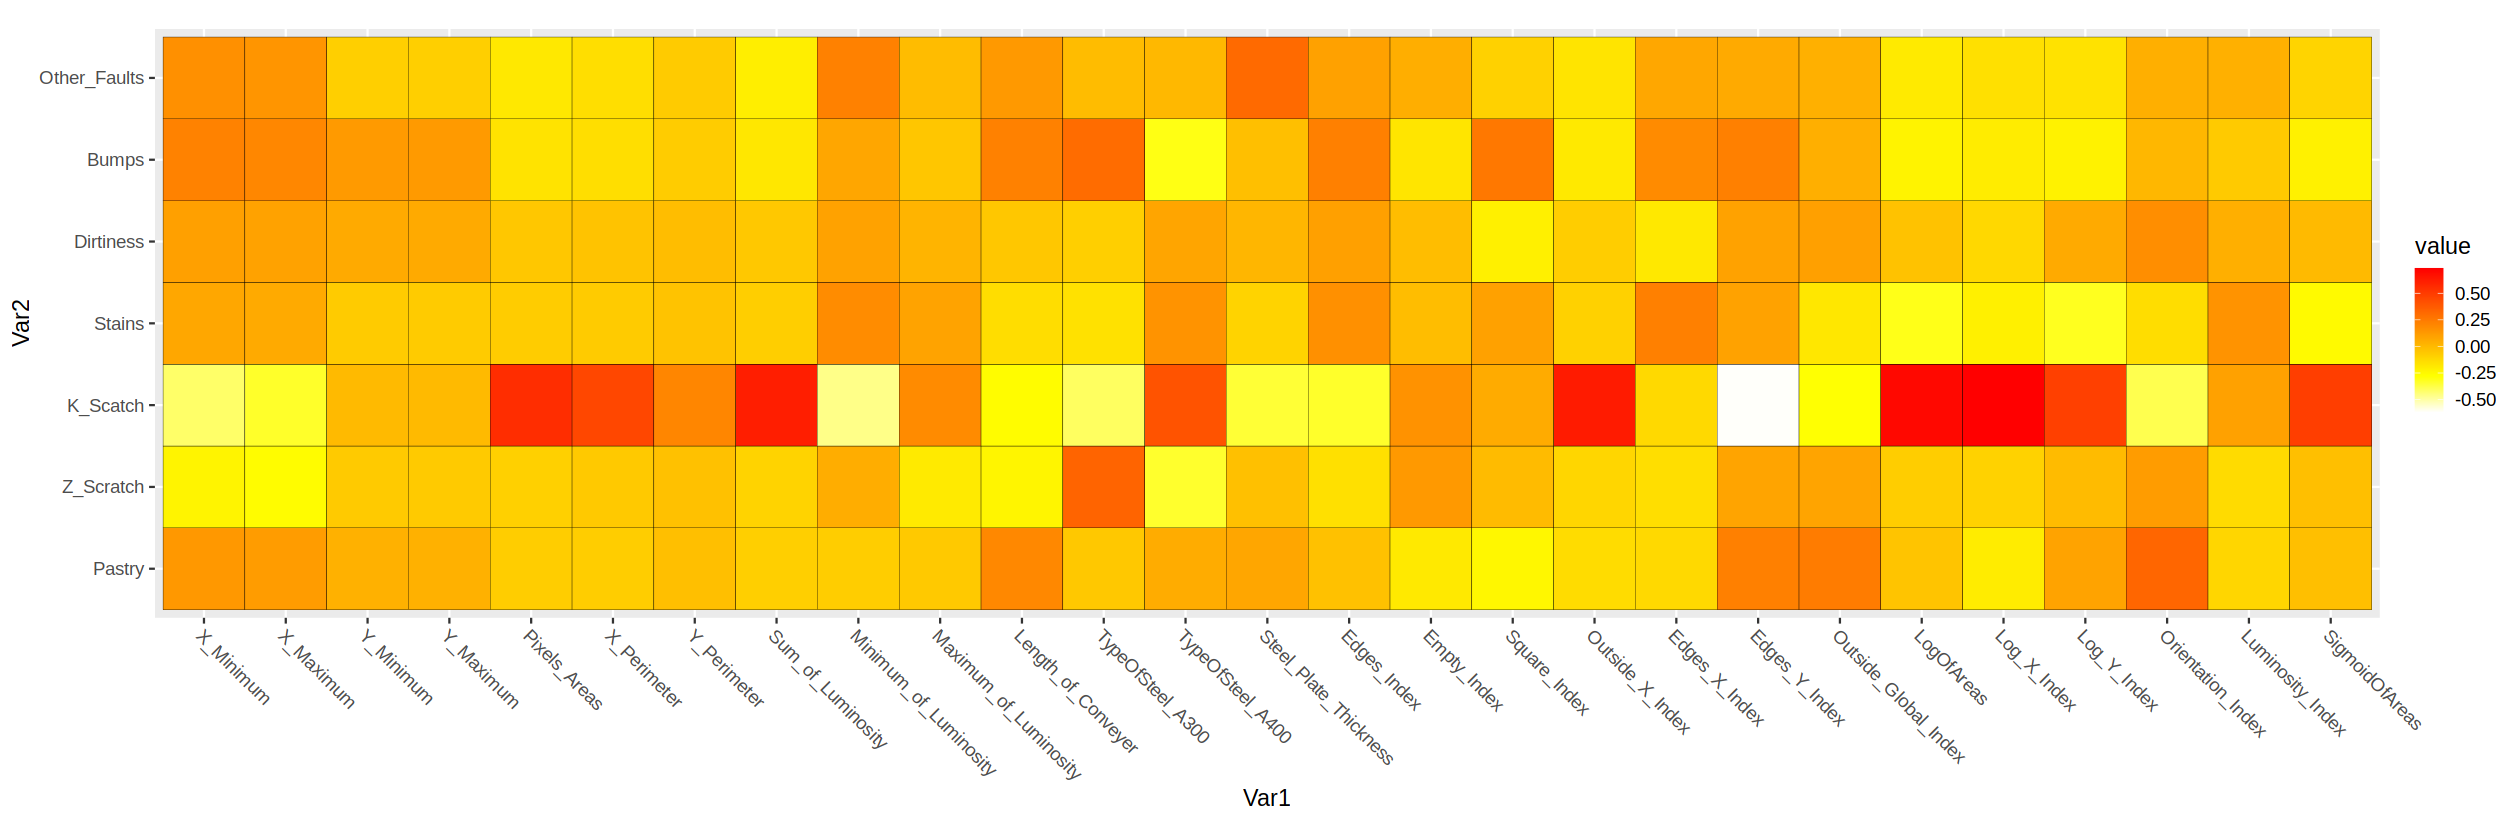

In [7]:
setPlotSize(3, 1)
ggplot(data = melt(cor(df.X, df[28:34])), aes(x = Var1, y = Var2, fill = value)) +
    geom_tile(color = "black") +
    scale_fill_gradientn(colours = heat.colors(100, rev = TRUE)) +
    coord_fixed() +
    theme_grey(base_size = 14) +
    theme(axis.text.x = element_text(angle = 315, hjust = 0))


In [8]:
setPlotSize(1, 1)


### PCA Tranformation


In [9]:
df.pca <- prcomp(df[, -length(df)], scale = TRUE)
df.pcaX <- df.pca$x


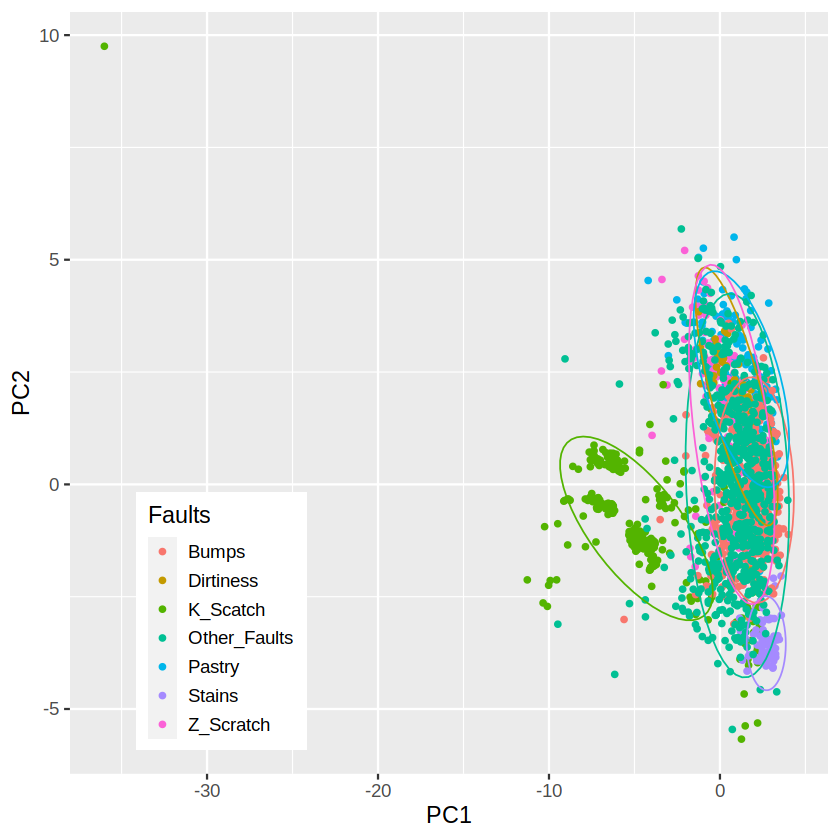

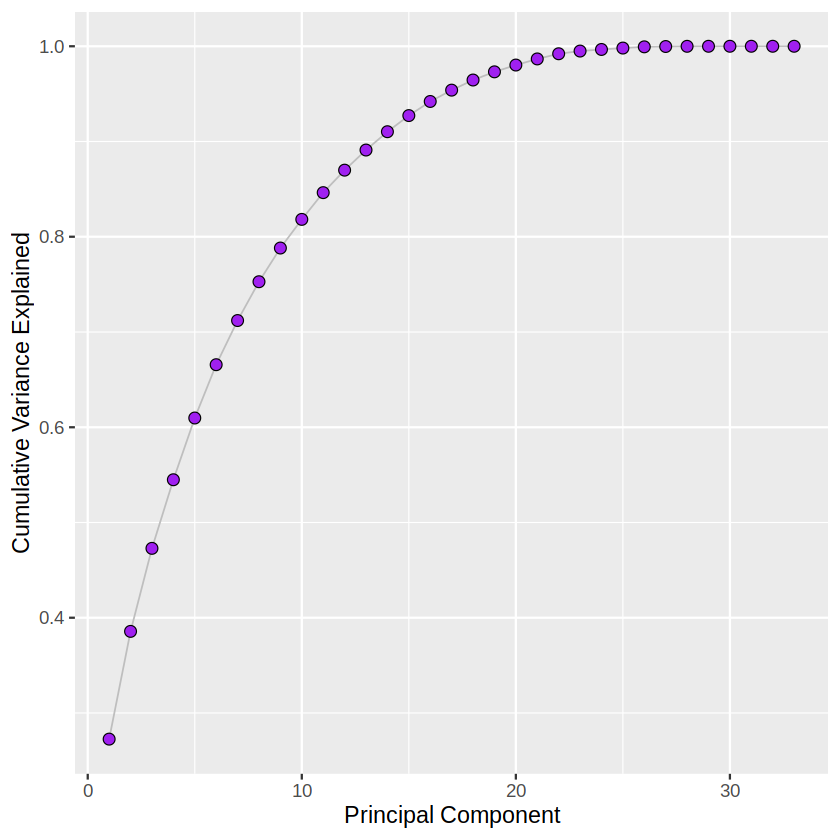

In [10]:
ggplot(cbind(df.pcaX, df.Y), aes(x = PC1, y = PC2, color = Faults)) +
    geom_point() +
    stat_ellipse(level = 0.95, show.legend = F) +
    theme_grey(base_size = 14) +
    theme(legend.position = c(0.2, 0.2))

impt <- melt(summary(df.pca)$importance[3, ])
ggplot(cbind(key = 1:nrow(impt), impt), aes(x = key, y = value, group = 1)) +
    geom_line(color = "grey") +
    geom_point(shape = 21, color = "black", fill = "purple", size = 3) +
    theme_grey(base_size = 14) +
    xlab("Principal Component") +
    ylab("Cumulative Variance Explained")


### Split dataset


In [11]:
set.seed(seed)
rand <- sample(nrow(df), nrow(df) * 0.8)

df.train.X <- df.X[rand, ]
df.train.Y <- df.Y[rand, ]
df.train.pcaX <- df.pcaX[rand, ]

df.test.X <- df.X[-rand, ]
df.test.Y <- df.Y[-rand, ]
df.test.pcaX <- df.pcaX[-rand, ]


## Classifiers


In [12]:
cv <- trainControl(method = "repeatedcv", number = 10)
train.Res <- list()
train.PcaRes <- list()
test.Res <- list()
test.PcaRes <- list()


### Naive Bayes


#### With PCA


In [13]:
set.seed(seed)
gnb.pca <- naiveBayes(df.train.pcaX, df.train.Y)
gnb.train.yPredPca <- predict(gnb.pca, df.train.pcaX)
gnb.test.yPredPca <- predict(gnb.pca, df.test.pcaX)

gnb.train.cmPca <- confusionMatrix(gnb.train.yPredPca, df.train.Y)
gnb.test.cmPca <- confusionMatrix(gnb.test.yPredPca, df.test.Y)
train.PcaRes <- c(train.PcaRes, gnb = gnb.train.cmPca$overall["AccuracyLower"])
test.PcaRes <- c(test.PcaRes, gnb = gnb.test.cmPca$overall["AccuracyLower"])


In [14]:
print("Naive Bayes training set with PCA Accuracy")
gnb.train.cmPca$overall["AccuracyLower"]

print("Naive Bayes testing set with PCA Accuracy")
gnb.test.cmPca$overall["AccuracyLower"]



[1] "Naive Bayes training set with PCA Accuracy"


AccuracyLower 
    0.9440691

[1] "Naive Bayes testing set with PCA Accuracy"


AccuracyLower 
    0.9309497

#### Without PCA


In [15]:
set.seed(seed)
gnb.model <- naiveBayes(df.train.X, df.train.Y)
gnb.train.yPred <- predict(gnb.model, df.train.X)
gnb.test.yPred <- predict(gnb.model, df.test.X)

gnb.train.cm <- confusionMatrix(gnb.train.yPred, df.train.Y)
gnb.test.cm <- confusionMatrix(gnb.test.yPred, df.test.Y)
train.Res <- c(train.Res, gnb = gnb.train.cm$overall["AccuracyLower"])
test.Res <- c(test.Res, gnb = gnb.test.cm$overall["AccuracyLower"])


In [16]:
print("Naive Bayes training set Accuracy")
gnb.train.cm$overall["AccuracyLower"]

print("Naive Bayes testing set Accuracy")
gnb.test.cm$overall["AccuracyLower"]



[1] "Naive Bayes training set Accuracy"


AccuracyLower 
    0.5854043

[1] "Naive Bayes testing set Accuracy"


AccuracyLower 
    0.5614094

In [17]:
summary(gnb.model)


          Length Class  Mode     
apriori    7     table  numeric  
tables    27     -none- list     
levels     7     -none- character
isnumeric 27     -none- logical  
call       3     -none- call     

##### Confusion Matrix Heat map and Area under Curve


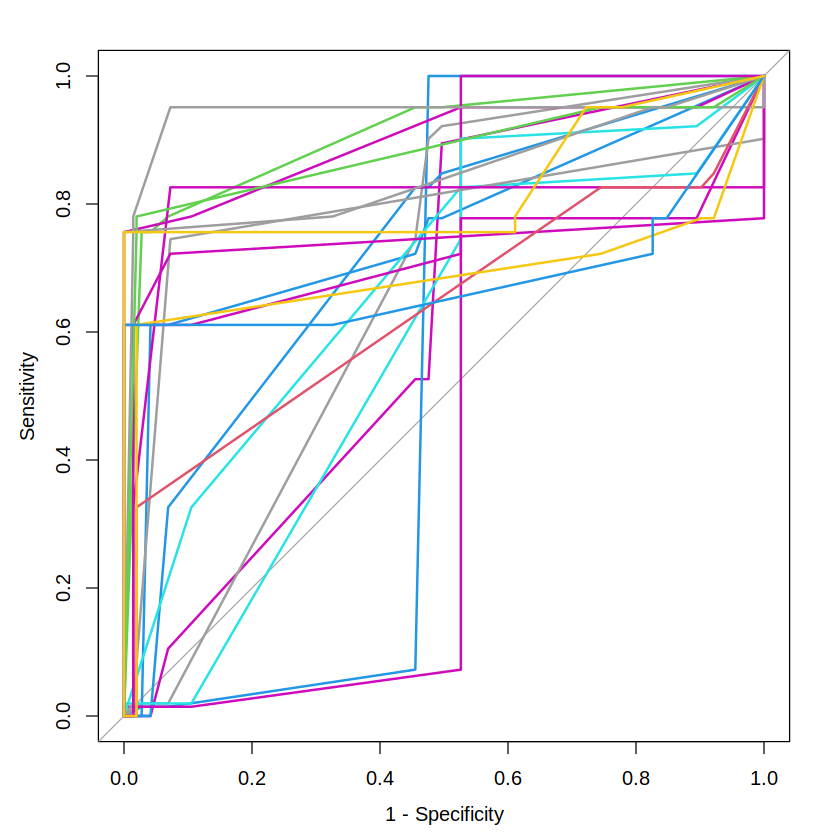

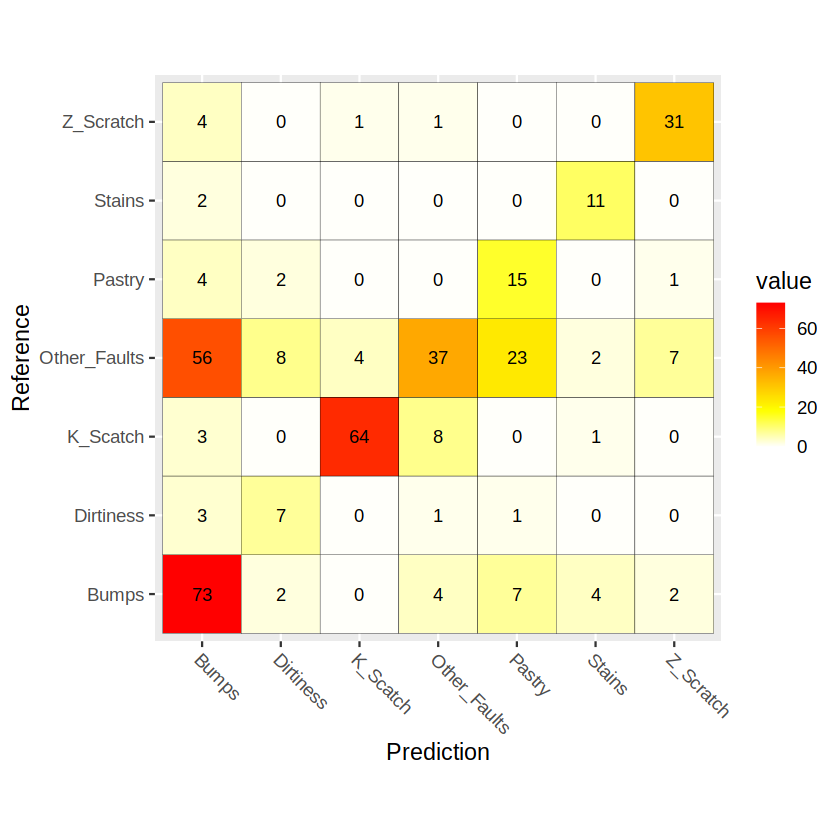

In [18]:
plotMultiRoc(gnb.test.yPred, as.numeric(df.test.Y), "<")
plotCM2Heatmap(gnb.test.cm$table)


### Multinomial Logistic Regression


#### With PCA


In [19]:
set.seed(seed)
mlg.pca <- train(df.train.pcaX, df.train.Y, method = "multinom", trControl = cv, trace = FALSE)
mlg.train.yPredPca <- predict(mlg.pca, df.train.pcaX)
mlg.test.yPredPca <- predict(mlg.pca, df.test.pcaX)

mlg.train.cmPca <- confusionMatrix(mlg.train.yPredPca, df.train.Y)
mlg.test.cmPca <- confusionMatrix(mlg.test.yPredPca, df.test.Y)
train.PcaRes <- c(train.PcaRes, mlg = mlg.train.cmPca$overall["AccuracyLower"])
test.PcaRes <- c(test.PcaRes, mlg = mlg.test.cmPca$overall["AccuracyLower"])


In [20]:
print("Multinomial Logistic Regression training set with PCA Accuracy")
mlg.train.cmPca$overall["AccuracyLower"]

print("Multinomial Logistic Regression testing set with PCA Accuracy")
mlg.test.cmPca$overall["AccuracyLower"]



[1] "Multinomial Logistic Regression training set with PCA Accuracy"


AccuracyLower 
     0.997626

[1] "Multinomial Logistic Regression testing set with PCA Accuracy"


AccuracyLower 
    0.9857609

#### Without PCA


In [21]:
set.seed(seed)
mlg.model <- train(df.train.X, df.train.Y, method = "multinom", trControl = cv, trace = FALSE)
mlg.train.yPred <- predict(mlg.model, df.train.X)
mlg.test.yPred <- predict(mlg.model, df.test.X)

mlg.train.cm <- confusionMatrix(mlg.train.yPred, df.train.Y)
mlg.test.cm <- confusionMatrix(mlg.test.yPred, df.test.Y)
train.Res <- c(train.Res, mlg = mlg.train.cm$overall["AccuracyLower"])
test.Res <- c(test.Res, mlg = mlg.test.cm$overall["AccuracyLower"])


In [22]:
print("Multinomial Logistic Regression training set Accuracy")
mlg.train.cm$overall["AccuracyLower"]

print("Multinomial Logistic Regression testing set Accuracy")
mlg.test.cm$overall["AccuracyLower"]



[1] "Multinomial Logistic Regression training set Accuracy"


AccuracyLower 
    0.7177579

[1] "Multinomial Logistic Regression testing set Accuracy"


AccuracyLower 
    0.6964689

Penalized Multinomial Regression 

1552 samples
  27 predictor
   7 classes: 'Bumps', 'Dirtiness', 'K_Scatch', 'Other_Faults', 'Pastry', 'Stains', 'Z_Scratch' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 1397, 1395, 1395, 1397, 1398, 1398, ... 
Resampling results across tuning parameters:

  decay  Accuracy   Kappa    
  0e+00  0.7056081  0.6215307
  1e-04  0.7036808  0.6193123
  1e-01  0.7036189  0.6186091

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was decay = 0.

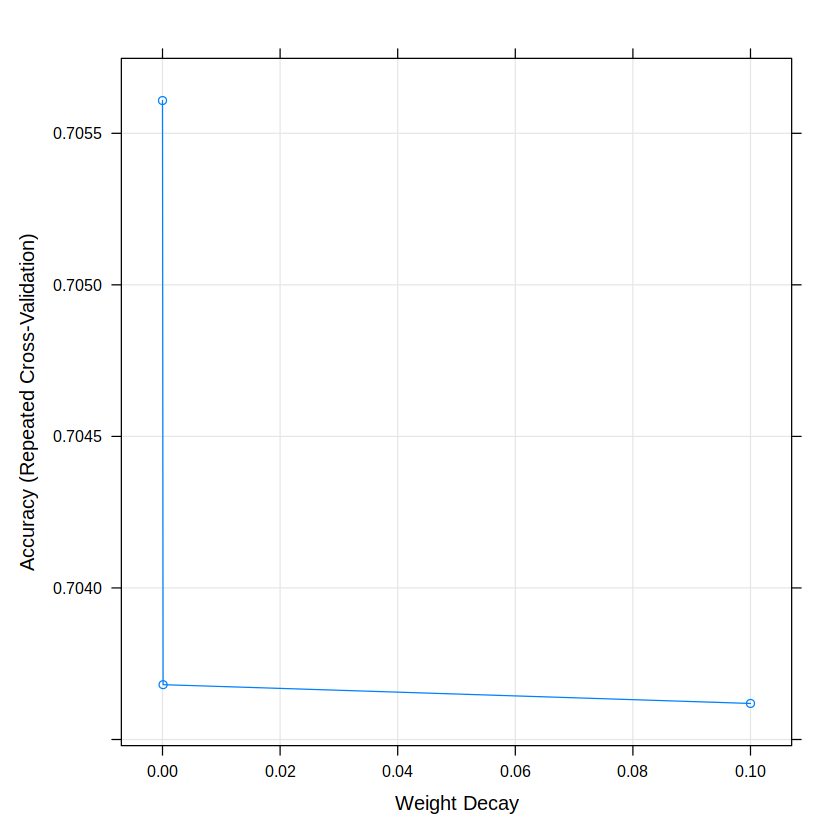

In [23]:
mlg.model
plot(mlg.model)


##### Confusion Matrix Heat map and Area under Curve


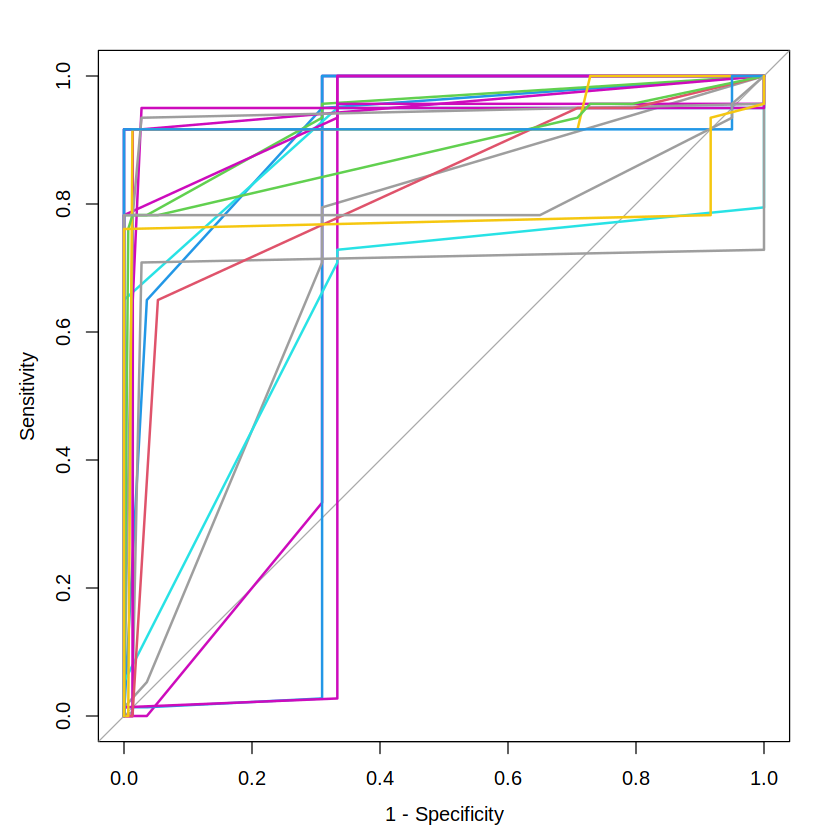

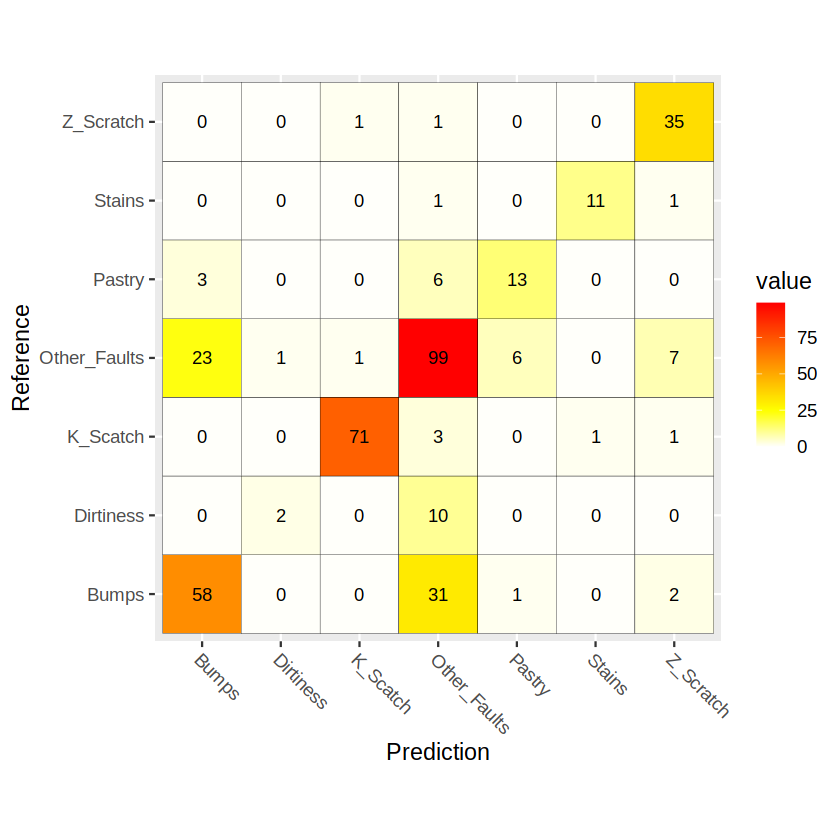

In [24]:
plotMultiRoc(mlg.test.yPred, as.numeric(df.test.Y), "<")
plotCM2Heatmap(mlg.test.cm$table)


### K Nearest Neighbor


#### With PCA


In [25]:
set.seed(seed)
knn.pca <- tune(gknn, df.train.pcaX, df.train.Y, ranges = list(k = 1:10))
knn.train.yPredPca <- predict(knn.pca$best.model, df.train.pcaX)
knn.test.yPredPca <- predict(knn.pca$best.model, df.test.pcaX)

knn.train.cmPca <- confusionMatrix(knn.train.yPredPca, df.train.Y)
knn.test.cmPca <- confusionMatrix(knn.test.yPredPca, df.test.Y)
train.PcaRes <- c(train.PcaRes, knn = knn.train.cmPca$overall["AccuracyLower"])
test.PcaRes <- c(test.PcaRes, knn = knn.test.cmPca$overall["AccuracyLower"])


In [26]:
print("K Nearest Neighbor training set with PCA Accuracy")
knn.train.cmPca$overall["AccuracyLower"]

print("K Nearest Neighbor testing set with PCA Accuracy")
knn.test.cmPca$overall["AccuracyLower"]



[1] "K Nearest Neighbor training set with PCA Accuracy"


AccuracyLower 
    0.9881826

[1] "K Nearest Neighbor testing set with PCA Accuracy"


AccuracyLower 
    0.9565359

#### Without PCA


In [27]:
set.seed(seed)
knn.model <- tune(gknn, df.train.X, df.train.Y, ranges = list(k = 1:10))
knn.train.yPred <- predict(knn.model$best.model, df.train.X)
knn.test.yPred <- predict(knn.model$best.model, df.test.X)

knn.train.cm <- confusionMatrix(knn.train.yPred, df.train.Y)
knn.test.cm <- confusionMatrix(knn.test.yPred, df.test.Y)
train.Res <- c(train.Res, knn = knn.train.cm$overall["AccuracyLower"])
test.Res <- c(test.Res, knn = knn.test.cm$overall["AccuracyLower"])


In [28]:
print("K Nearest Neighbor training set Accuracy")
knn.train.cm$overall["AccuracyLower"]

print("K Nearest Neighbor testing set Accuracy")
knn.test.cm$overall["AccuracyLower"]



[1] "K Nearest Neighbor training set Accuracy"


AccuracyLower 
     0.997626

[1] "K Nearest Neighbor testing set Accuracy"


AccuracyLower 
    0.6964689


Parameter tuning of ‘gknn’:

- sampling method: 10-fold cross validation 

- best parameters:
 k
 1

- best performance: 0.27 

- Detailed performance results:
    k     error dispersion
1   1 0.2700000 0.03138458
2   2 0.2977047 0.02692294
3   3 0.2815964 0.02074165
4   4 0.2906203 0.02397171
5   5 0.2809636 0.02673920
6   6 0.2771009 0.02602793
7   7 0.2777585 0.03486108
8   8 0.2719603 0.03036039
9   9 0.2771092 0.03256651
10 10 0.2777502 0.03025606


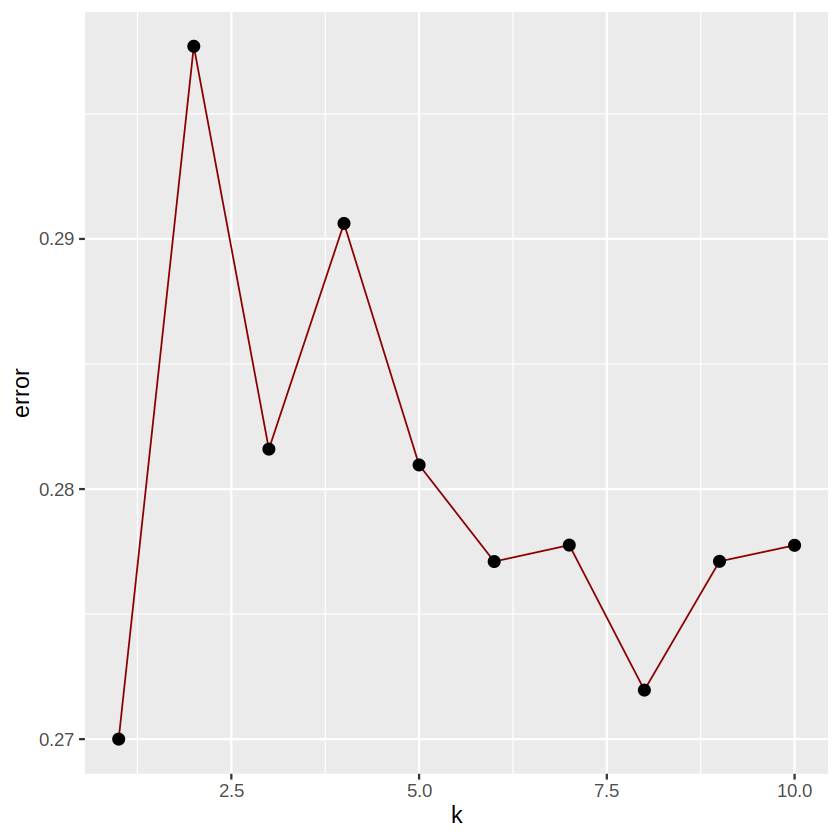

In [29]:
summary(knn.model)
ggplot(knn.model$performances, aes(x = k, y = error)) +
    geom_line(color = "darkred") +
    geom_point(shape = 21, color = "black", fill = "black", size = 3) +
    theme_grey(base_size = 14)



##### Confusion Matrix Heat map and Area under Curve


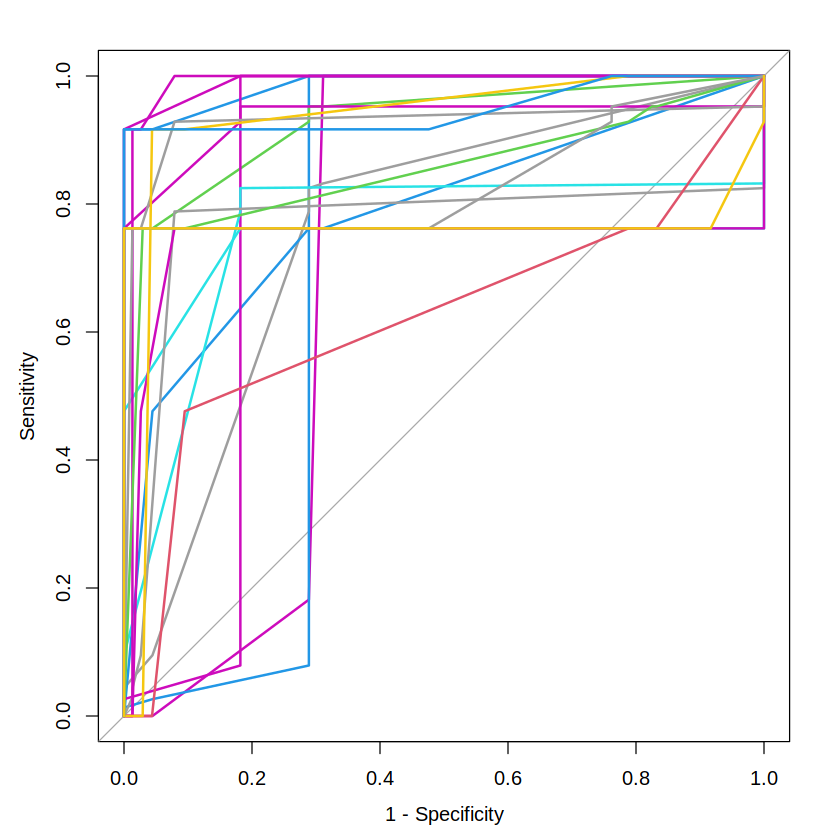

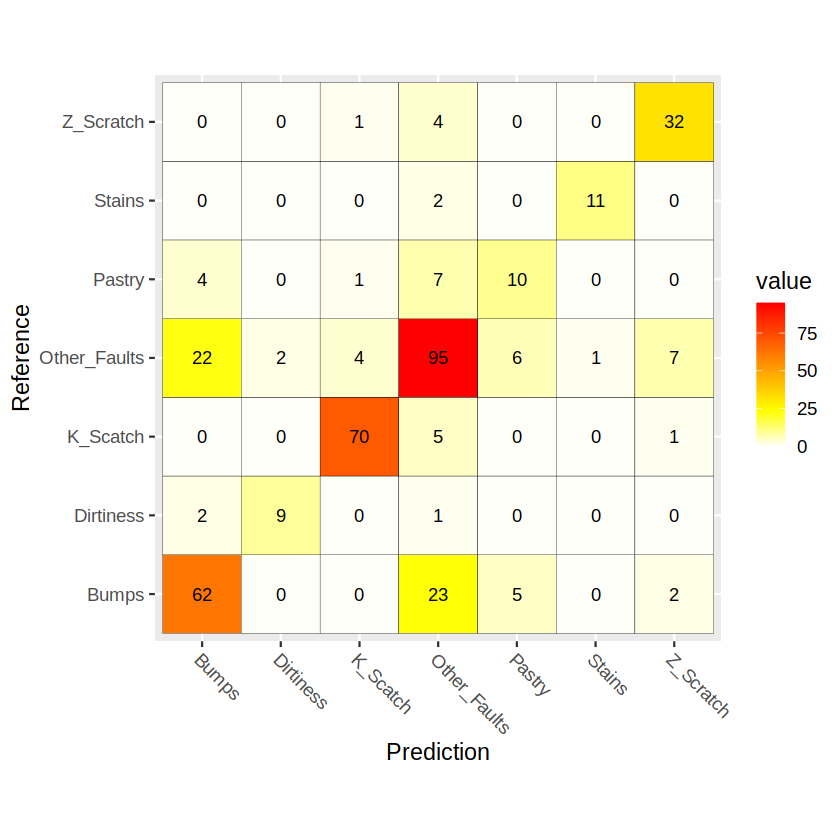

In [30]:
plotMultiRoc(knn.test.yPred, as.numeric(df.test.Y), "<")
plotCM2Heatmap(knn.test.cm$table)


### Random Forest


#### With PCA


In [31]:
set.seed(seed)
rf.pca <- train(df.train.pcaX, df.train.Y, method = "rf", trControl = cv)
rf.train.yPredPca <- predict(rf.pca, df.train.pcaX)
rf.test.yPredPca <- predict(rf.pca, df.test.pcaX)

rf.train.cmPca <- confusionMatrix(rf.train.yPredPca, df.train.Y)
rf.test.cmPca <- confusionMatrix(rf.test.yPredPca, df.test.Y)
train.PcaRes <- c(train.PcaRes, rf = rf.train.cmPca$overall["AccuracyLower"])
test.PcaRes <- c(test.PcaRes, rf = rf.test.cmPca$overall["AccuracyLower"])


In [32]:
print("Random Forest training set with PCA Accuracy")
rf.train.cmPca$overall["AccuracyLower"]

print("Random Forest testing set with PCA Accuracy")
rf.test.cmPca$overall["AccuracyLower"]



[1] "Random Forest training set with PCA Accuracy"


AccuracyLower 
     0.997626

[1] "Random Forest testing set with PCA Accuracy"


AccuracyLower 
    0.9702607

#### Without PCA


In [33]:
set.seed(seed)
rf.model <- train(df.train.X, df.train.Y, method = "rf", trControl = cv)
rf.train.yPred <- predict(rf.model, df.train.X)
rf.test.yPred <- predict(rf.model, df.test.X)

rf.train.cm <- confusionMatrix(rf.train.yPred, df.train.Y)
rf.test.cm <- confusionMatrix(rf.test.yPred, df.test.Y)
train.Res <- c(train.Res, rf = rf.train.cm$overall["AccuracyLower"])
test.Res <- c(test.Res, rf = rf.test.cm$overall["AccuracyLower"])


In [34]:
print("Random Forest training set with PCA Accuracy")
rf.train.cm$overall["AccuracyLower"]

print("Random Forest testing set with PCA Accuracy")
rf.test.cm$overall["AccuracyLower"]


[1] "Random Forest training set with PCA Accuracy"


AccuracyLower 
     0.997626

[1] "Random Forest testing set with PCA Accuracy"


AccuracyLower 
    0.7370747

Random Forest 

1552 samples
  27 predictor
   7 classes: 'Bumps', 'Dirtiness', 'K_Scatch', 'Other_Faults', 'Pastry', 'Stains', 'Z_Scratch' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 1397, 1395, 1395, 1397, 1398, 1398, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.7635715  0.6920532
  14    0.7725504  0.7049538
  27    0.7828734  0.7185713

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 27.

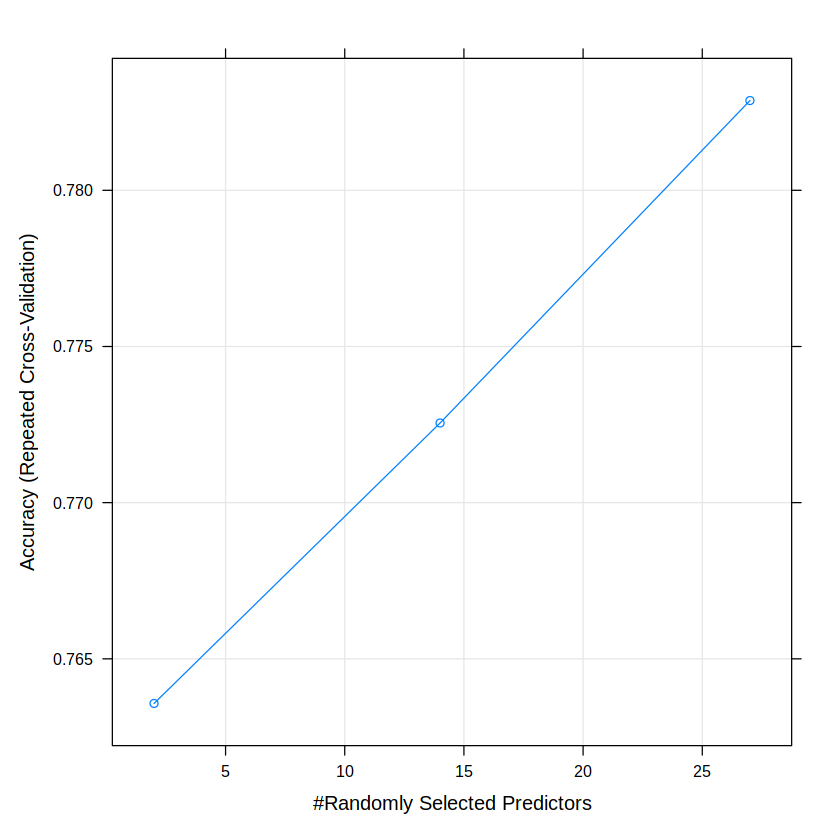

In [35]:
rf.model
plot(rf.model)


##### Confusion Matrix Heat map and Area under Curve


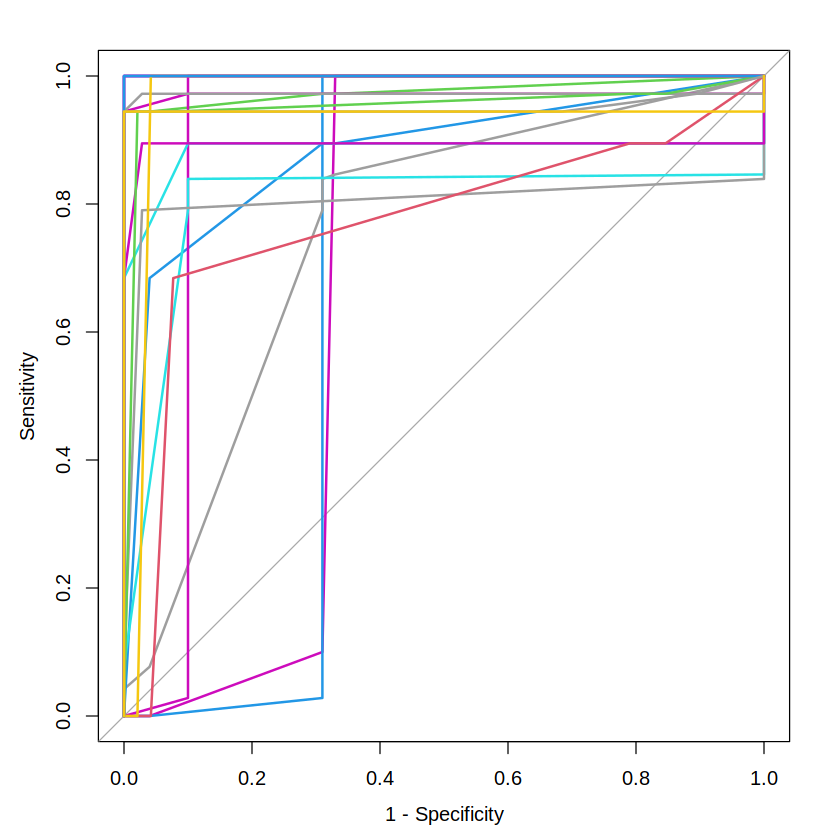

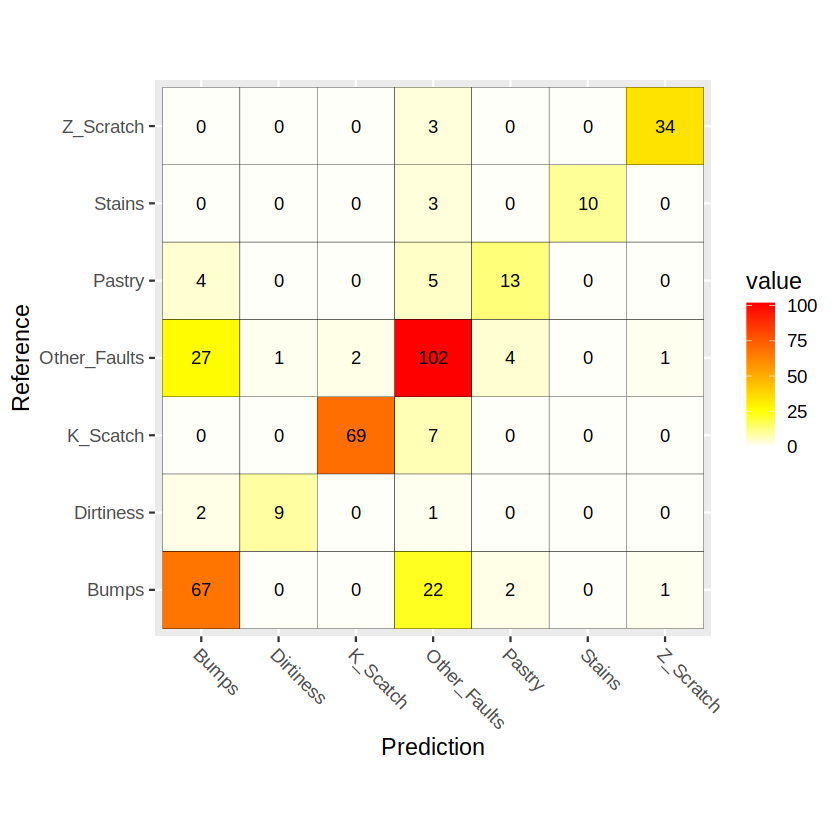

In [36]:
plotMultiRoc(rf.test.yPred, as.numeric(df.test.Y), "<")
plotCM2Heatmap(rf.test.cm$table)


### Boosting


#### With PCA


In [37]:
set.seed(seed)
bst.pca <- train(df.train.pcaX, df.train.Y, method = "gbm", trControl = cv, verbose = FALSE)
bst.train.yPredPca <- predict(bst.pca, df.train.pcaX)
bst.test.yPredPca <- predict(bst.pca, df.test.pcaX)

bst.train.cmPca <- confusionMatrix(bst.train.yPredPca, df.train.Y)
bst.test.cmPca <- confusionMatrix(bst.test.yPredPca, df.test.Y)
train.PcaRes <- c(train.PcaRes, bst = bst.train.cmPca$overall["AccuracyLower"])
test.PcaRes <- c(test.PcaRes, bst = bst.test.cmPca$overall["AccuracyLower"])


In [38]:
print("Boosting training set with PCA Accuracy")
bst.train.cmPca$overall["AccuracyLower"]

print("Boosting testing set with PCA Accuracy")
bst.test.cmPca$overall["AccuracyLower"]


[1] "Boosting training set with PCA Accuracy"


AccuracyLower 
     0.997626

[1] "Boosting testing set with PCA Accuracy"


AccuracyLower 
    0.9905618

#### Without PCA


In [39]:
set.seed(seed)
bst.model <- train(df.train.X, df.train.Y, method = "gbm", trControl = cv, verbose = FALSE)
bst.train.yPred <- predict(bst.model, df.train.X)
bst.test.yPred <- predict(bst.model, df.test.X)

bst.train.cm <- confusionMatrix(bst.train.yPred, df.train.Y)
bst.test.cm <- confusionMatrix(bst.test.yPred, df.test.Y)
train.Res <- c(train.Res, bst = bst.train.cm$overall["AccuracyLower"])
test.Res <- c(test.Res, bst = bst.test.cm$overall["AccuracyLower"])


In [40]:
print("Boosting training set Accuracy")
bst.train.cm$overall["AccuracyLower"]

print("Boosting testing set Accuracy")
bst.test.cm$overall["AccuracyLower"]


[1] "Boosting training set Accuracy"


AccuracyLower 
     0.946212

[1] "Boosting testing set Accuracy"


AccuracyLower 
    0.7234864

Stochastic Gradient Boosting 

1552 samples
  27 predictor
   7 classes: 'Bumps', 'Dirtiness', 'K_Scatch', 'Other_Faults', 'Pastry', 'Stains', 'Z_Scratch' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 1397, 1395, 1395, 1397, 1398, 1398, ... 
Resampling results across tuning parameters:

  interaction.depth  n.trees  Accuracy   Kappa    
  1                   50      0.7191488  0.6322553
  1                  100      0.7320031  0.6520644
  1                  150      0.7390380  0.6625470
  2                   50      0.7403824  0.6632255
  2                  100      0.7584475  0.6875999
  2                  150      0.7629639  0.6934045
  3                   50      0.7551756  0.6822838
  3                  100      0.7590344  0.6888130
  3                  150      0.7635839  0.6946416

Tuning parameter 'shrinkage' was held constant at a value of 0.1

Tuning parameter 'n.minobsinnode' was held constant at a value of 10
Accuracy w

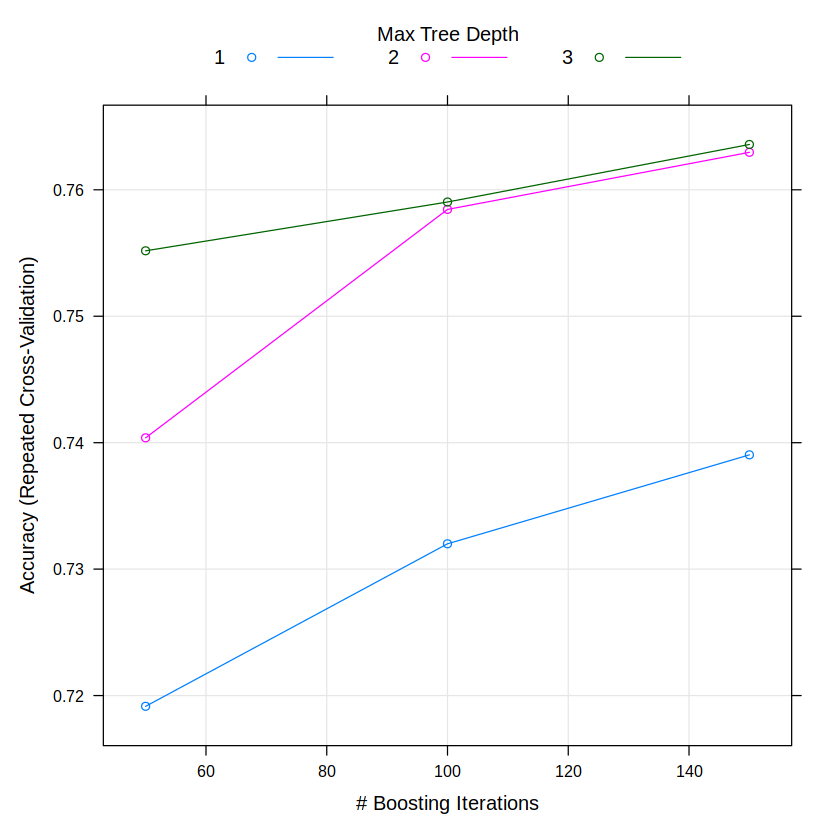

In [41]:
bst.model
plot(bst.model)


##### Confusion Matrix Heat map and Area under Curve


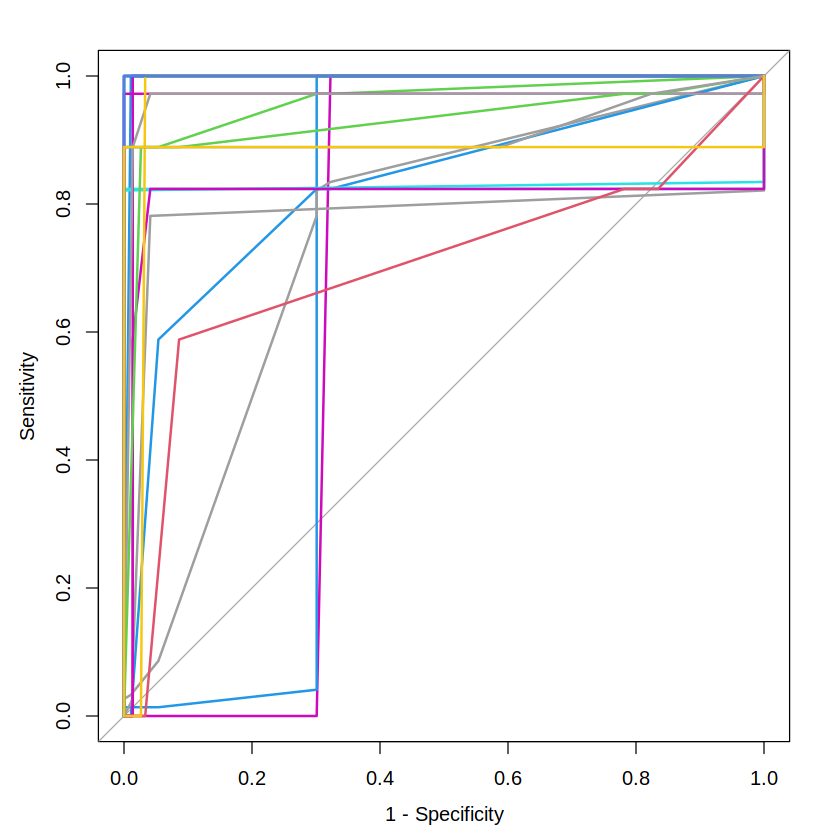

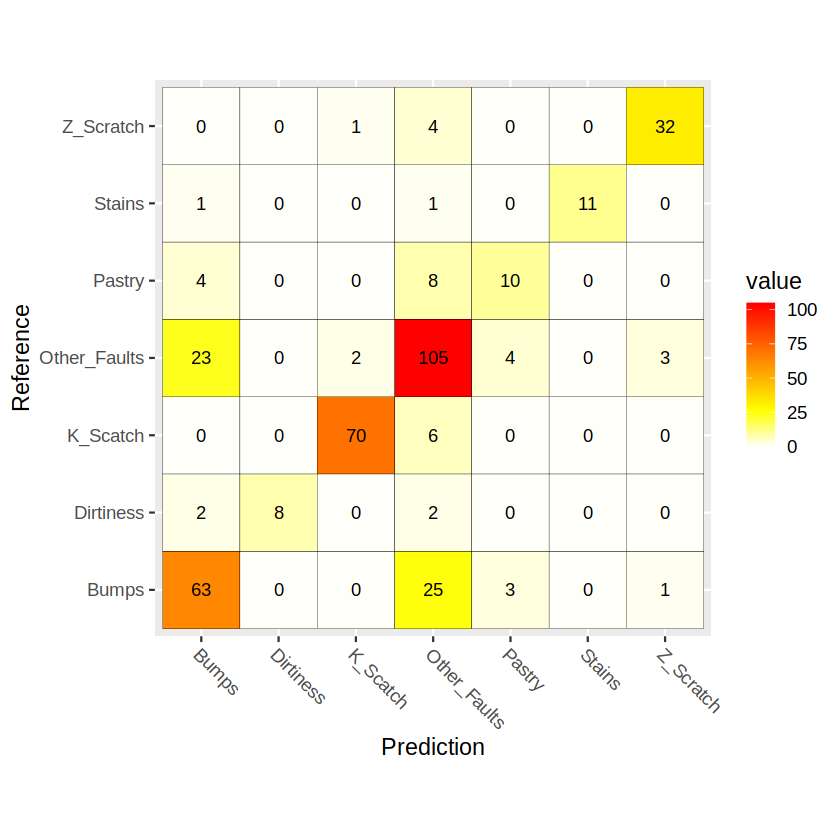

In [42]:
plotMultiRoc(bst.test.yPred, as.numeric(df.test.Y), "<")
plotCM2Heatmap(bst.test.cm$table)


### Learning Vector Quantization


#### With PCA


In [43]:
set.seed(seed)
lvq.pca <- train(df.train.pcaX, df.train.Y, method = "lvq", trControl = cv)
lvq.train.yPredPca <- predict(lvq.pca, df.train.pcaX)
lvq.test.yPredPca <- predict(lvq.pca, df.test.pcaX)

lvq.train.cmPca <- confusionMatrix(lvq.train.yPredPca, df.train.Y)
lvq.test.cmPca <- confusionMatrix(lvq.test.yPredPca, df.test.Y)
train.PcaRes <- c(train.PcaRes, lvq = lvq.train.cmPca$overall["AccuracyLower"])
test.PcaRes <- c(test.PcaRes, lvq = lvq.test.cmPca$overall["AccuracyLower"])


In [44]:
print("Learning Vector Quantization training set with PCA Accuracy")
lvq.train.cmPca$overall["AccuracyLower"]

print("Learning Vector Quantization testing set with PCA Accuracy")
lvq.test.cmPca$overall["AccuracyLower"]


[1] "Learning Vector Quantization training set with PCA Accuracy"


AccuracyLower 
     0.964331

[1] "Learning Vector Quantization testing set with PCA Accuracy"


AccuracyLower 
    0.9371973

#### Without PCA


In [45]:
set.seed(seed)
lvq.model <- train(df.train.X, df.train.Y, method = "lvq", trControl = cv)
lvq.train.yPred <- predict(lvq.model, df.train.X)
lvq.test.yPred <- predict(lvq.model, df.test.X)

lvq.train.cm <- confusionMatrix(lvq.train.yPred, df.train.Y)
lvq.test.cm <- confusionMatrix(lvq.test.yPred, df.test.Y)
train.Res <- c(train.Res, lvq = lvq.train.cm$overall["AccuracyLower"])
test.Res <- c(test.Res, lvq = lvq.test.cm$overall["AccuracyLower"])


In [46]:
print("Learning Vector Quantization training set Accuracy")
lvq.train.cm$overall["AccuracyLower"]

print("Learning Vector Quantization testing set Accuracy")
lvq.test.cm$overall["AccuracyLower"]


[1] "Learning Vector Quantization training set Accuracy"


AccuracyLower 
    0.7495419

[1] "Learning Vector Quantization testing set Accuracy"


AccuracyLower 
    0.6669737

Learning Vector Quantization 

1552 samples
  27 predictor
   7 classes: 'Bumps', 'Dirtiness', 'K_Scatch', 'Other_Faults', 'Pastry', 'Stains', 'Z_Scratch' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 1397, 1395, 1395, 1397, 1398, 1398, ... 
Resampling results across tuning parameters:

  size  k   Accuracy   Kappa    
   55    1  0.6702883  0.5805000
   55    6  0.6688773  0.5752882
   55   11  0.6662684  0.5721432
   82    1  0.6693742  0.5793639
   82    6  0.6804209  0.5905890
   82   11  0.6792960  0.5906694
  110    1  0.6927662  0.6078704
  110    6  0.6945780  0.6093202
  110   11  0.6902600  0.6034987

Accuracy was used to select the optimal model using the largest value.
The final values used for the model were size = 110 and k = 6.

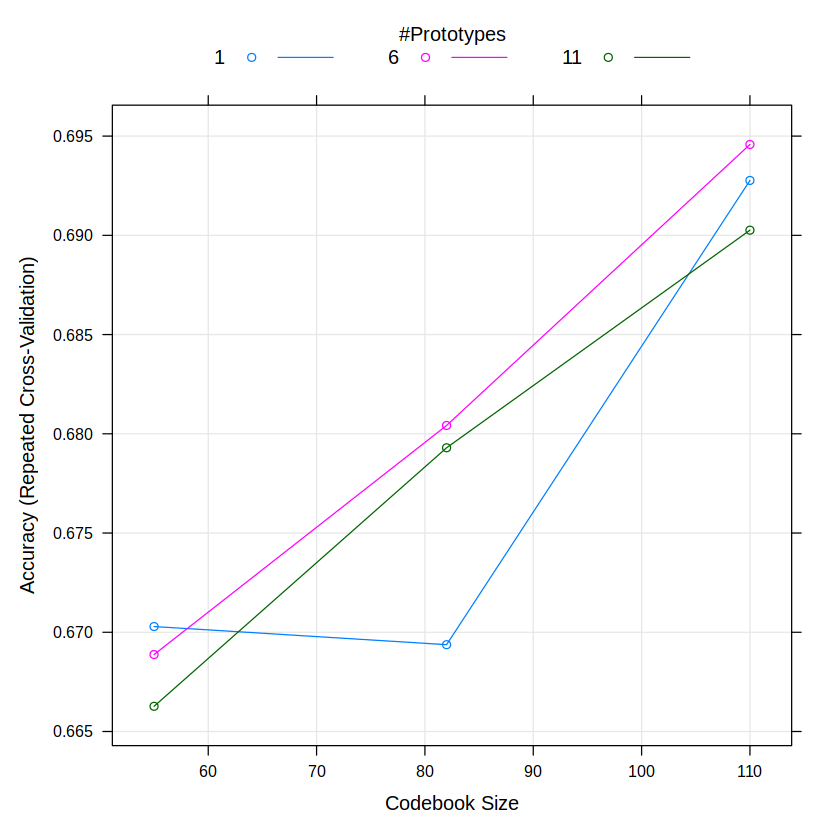

In [47]:
lvq.model
plot(lvq.model)


##### Confusion Matrix Heat map and Area under Curve


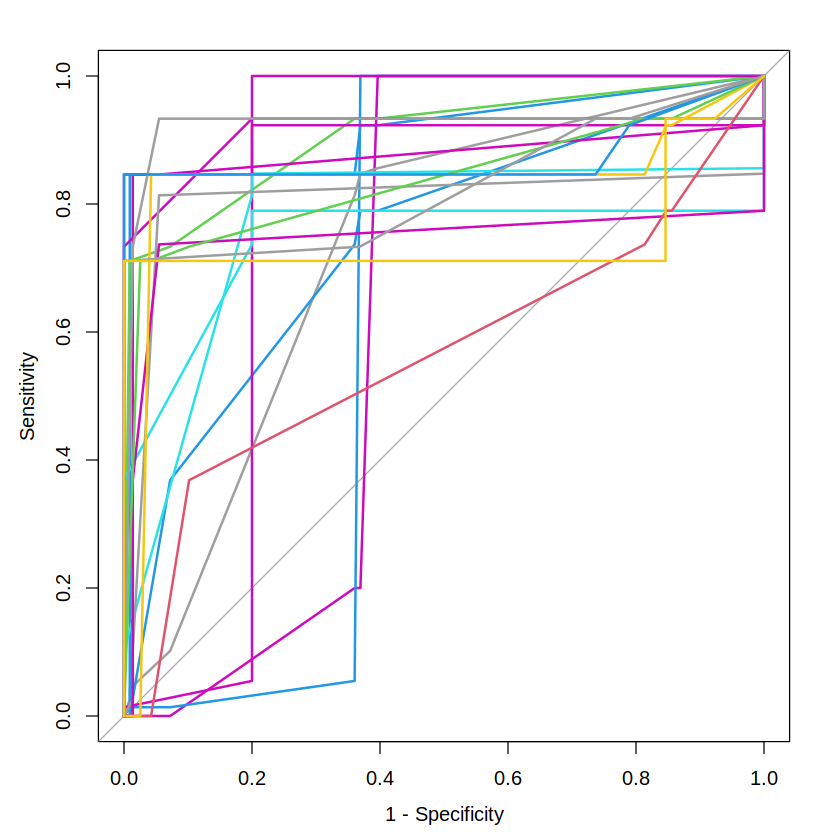

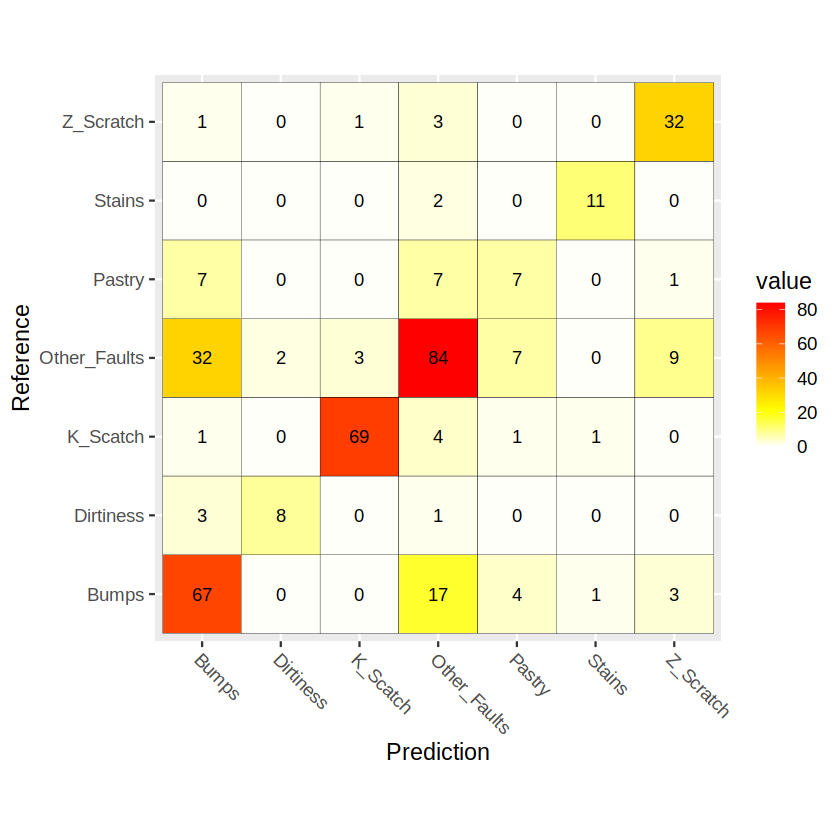

In [48]:
plotMultiRoc(lvq.test.yPred, as.numeric(df.test.Y), "<")
plotCM2Heatmap(lvq.test.cm$table)


### Support Vector Machine


#### With PCA


##### Linear Kernel


In [49]:
set.seed(seed)
tuning <- expand.grid(C = 2^seq(-5, 5, 1))
svml.pca <- train(df.train.pcaX, df.train.Y, method = "svmLinear", trControl = cv, tuneGrid = tuning)
svml.train.yPredPca <- predict(svml.pca, df.train.pcaX)
svml.test.yPredPca <- predict(svml.pca, df.test.pcaX)

svml.train.cmPca <- confusionMatrix(svml.train.yPredPca, df.train.Y)
svml.test.cmPca <- confusionMatrix(svml.test.yPredPca, df.test.Y)
train.PcaRes <- c(train.PcaRes, svml = svml.train.cmPca$overall["AccuracyLower"])
test.PcaRes <- c(test.PcaRes, svml = svml.test.cmPca$overall["AccuracyLower"])


In [50]:
print("Support Vector Machine Linear Kernel training set with PCA Accuracy")
svml.train.cmPca$overall["AccuracyLower"]

print("Support Vector Machine Linear Kernel testing set with PCA Accuracy")
svml.test.cmPca$overall["AccuracyLower"]


[1] "Support Vector Machine Linear Kernel training set with PCA Accuracy"


AccuracyLower 
     0.997626

[1] "Support Vector Machine Linear Kernel testing set with PCA Accuracy"


AccuracyLower 
    0.9905618

##### Polynomial Kernel


In [51]:
set.seed(seed)
svmp.pca <- train(df.train.pcaX, df.train.Y, method = "svmPoly", trControl = cv)
svmp.train.yPredPca <- predict(svmp.pca, df.train.pcaX)
svmp.test.yPredPca <- predict(svmp.pca, df.test.pcaX)

svmp.train.cmPca <- confusionMatrix(svmp.train.yPredPca, df.train.Y)
svmp.test.cmPca <- confusionMatrix(svmp.test.yPredPca, df.test.Y)
train.PcaRes <- c(train.PcaRes, svmp = svmp.train.cmPca$overall["AccuracyLower"])
test.PcaRes <- c(test.PcaRes, svmp = svmp.test.cmPca$overall["AccuracyLower"])


In [52]:
print("Support Vector Machine Polynomial Kernel training set with PCA Accuracy")
svmp.train.cmPca$overall["AccuracyLower"]

print("Support Vector Machine Polynomial Kernel testing set with PCA Accuracy")
svmp.test.cmPca$overall["AccuracyLower"]


[1] "Support Vector Machine Polynomial Kernel training set with PCA Accuracy"


AccuracyLower 
     0.997626

[1] "Support Vector Machine Polynomial Kernel testing set with PCA Accuracy"


AccuracyLower 
    0.9905618

##### Radial Kernel


In [53]:
set.seed(seed)
svmr.pca <- train(df.train.pcaX, df.train.Y, method = "svmRadial", trControl = cv)
svmr.train.yPredPca <- predict(svmr.pca, df.train.pcaX)
svmr.test.yPredPca <- predict(svmr.pca, df.test.pcaX)

svmr.train.cmPca <- confusionMatrix(svmr.train.yPredPca, df.train.Y)
svmr.test.cmPca <- confusionMatrix(svmr.test.yPredPca, df.test.Y)
train.PcaRes <- c(train.PcaRes, svmr = svmr.train.cmPca$overall["AccuracyLower"])
test.PcaRes <- c(test.PcaRes, svmr = svmr.test.cmPca$overall["AccuracyLower"])


In [54]:
print("Support Vector Machine Radial Kernel training set with PCA Accuracy")
svmr.train.cmPca$overall["AccuracyLower"]

print("Support Vector Machine Radial Kernel testing set with PCA Accuracy")
svmr.test.cmPca$overall["AccuracyLower"]


[1] "Support Vector Machine Radial Kernel training set with PCA Accuracy"


AccuracyLower 
    0.9924979

[1] "Support Vector Machine Radial Kernel testing set with PCA Accuracy"


AccuracyLower 
    0.9776286

#### Without PCA


##### Linear Kernel


In [55]:
set.seed(seed)
tuning <- expand.grid(C = 2^seq(-5, 5, 1))
svml.model <- train(df.train.X, df.train.Y, method = "svmLinear", trControl = cv, tuneGrid = tuning)
svml.train.yPred <- predict(svml.model, df.train.X)
svml.test.yPred <- predict(svml.model, df.test.X)

svml.train.cm <- confusionMatrix(svml.train.yPred, df.train.Y)
svml.test.cm <- confusionMatrix(svml.test.yPred, df.test.Y)
train.Res <- c(train.Res, svml = svml.train.cm$overall["AccuracyLower"])
test.Res <- c(test.Res, svml = svml.test.cm$overall["AccuracyLower"])


In [56]:
print("Support Vector Machine Linear Kernel training set Accuracy")
svml.train.cm$overall["AccuracyLower"]

print("Support Vector Machine Linear Kernel testing set Accuracy")
svml.test.cm$overall["AccuracyLower"]


[1] "Support Vector Machine Linear Kernel training set Accuracy"


AccuracyLower 
    0.7250287

[1] "Support Vector Machine Linear Kernel testing set Accuracy"


AccuracyLower 
    0.6857174

Support Vector Machines with Linear Kernel 

1552 samples
  27 predictor
   7 classes: 'Bumps', 'Dirtiness', 'K_Scatch', 'Other_Faults', 'Pastry', 'Stains', 'Z_Scratch' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 1397, 1395, 1395, 1397, 1398, 1398, ... 
Resampling results across tuning parameters:

  C         Accuracy   Kappa    
   0.03125  0.7004545  0.6066321
   0.06250  0.7082090  0.6200125
   0.12500  0.7133499  0.6291377
   0.25000  0.7146196  0.6309865
   0.50000  0.7165345  0.6343772
   1.00000  0.7210424  0.6400224
   2.00000  0.7230153  0.6422261
   4.00000  0.7210921  0.6393130
   8.00000  0.7178413  0.6354679
  16.00000  0.7171799  0.6349848
  32.00000  0.7133501  0.6308847

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was C = 2.

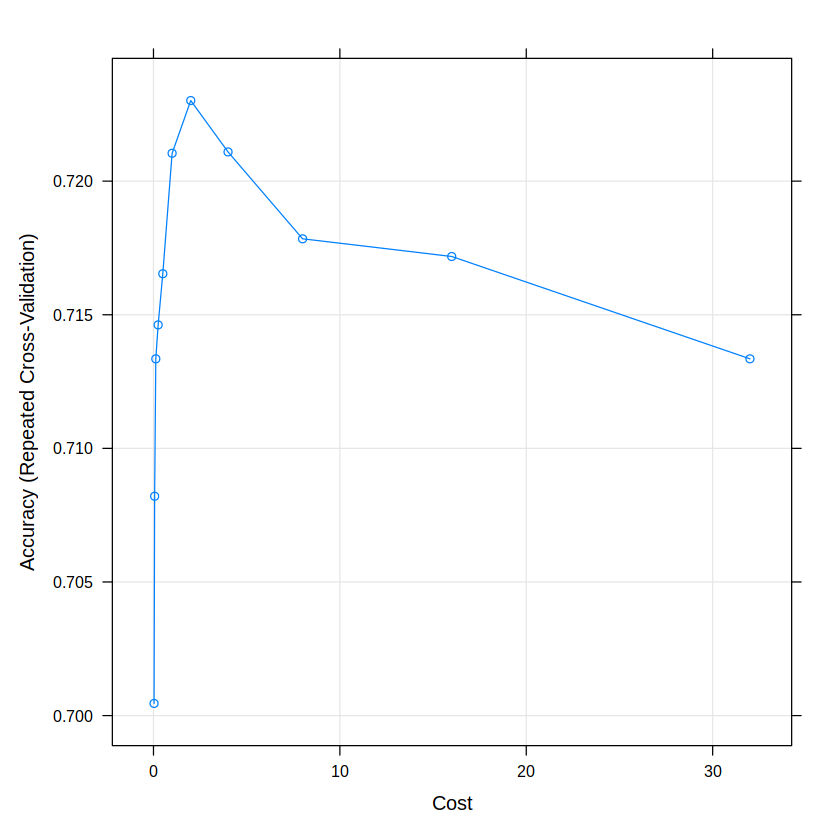

In [57]:
svml.model
plot(svml.model)


##### Polynomial Kernel


In [58]:
set.seed(seed)
svmp.model <- train(df.train.X, df.train.Y, method = "svmPoly", trControl = cv)
svmp.train.yPred <- predict(svmp.model, df.train.X)
svmp.test.yPred <- predict(svmp.model, df.test.X)

svmp.train.cm <- confusionMatrix(svmp.train.yPred, df.train.Y)
svmp.test.cm <- confusionMatrix(svmp.test.yPred, df.test.Y)
train.Res <- c(train.Res, svmp = svmp.train.cm$overall["AccuracyLower"])
test.Res <- c(test.Res, svmp = svmp.test.cm$overall["AccuracyLower"])


In [59]:
print("Support Vector Machine Polynomial Kernel training set Accuracy")
svmp.train.cm$overall["AccuracyLower"]

print("Support Vector Machine Polynomial Kernel testing set Accuracy")
svmp.test.cm$overall["AccuracyLower"]


[1] "Support Vector Machine Polynomial Kernel training set Accuracy"


AccuracyLower 
    0.8609106

[1] "Support Vector Machine Polynomial Kernel testing set Accuracy"


AccuracyLower 
    0.7018562

Support Vector Machines with Polynomial Kernel 

1552 samples
  27 predictor
   7 classes: 'Bumps', 'Dirtiness', 'K_Scatch', 'Other_Faults', 'Pastry', 'Stains', 'Z_Scratch' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 1397, 1395, 1395, 1397, 1398, 1398, ... 
Resampling results across tuning parameters:

  degree  scale  C     Accuracy   Kappa    
  1       0.001  0.25  0.5026099  0.2675620
  1       0.001  0.50  0.5045082  0.2716578
  1       0.001  1.00  0.5045082  0.2717562
  1       0.010  0.25  0.5251585  0.3078909
  1       0.010  0.50  0.6237188  0.4835367
  1       0.010  1.00  0.6650192  0.5516766
  1       0.100  0.25  0.6985479  0.6033523
  1       0.100  0.50  0.7024232  0.6115400
  1       0.100  1.00  0.7094913  0.6232100
  2       0.001  0.25  0.5045082  0.2716578
  2       0.001  0.50  0.5045082  0.2716531
  2       0.001  1.00  0.5070890  0.2754839
  2       0.010  0.25  0.6501676  0.5239752
  2       0.010  0.50 

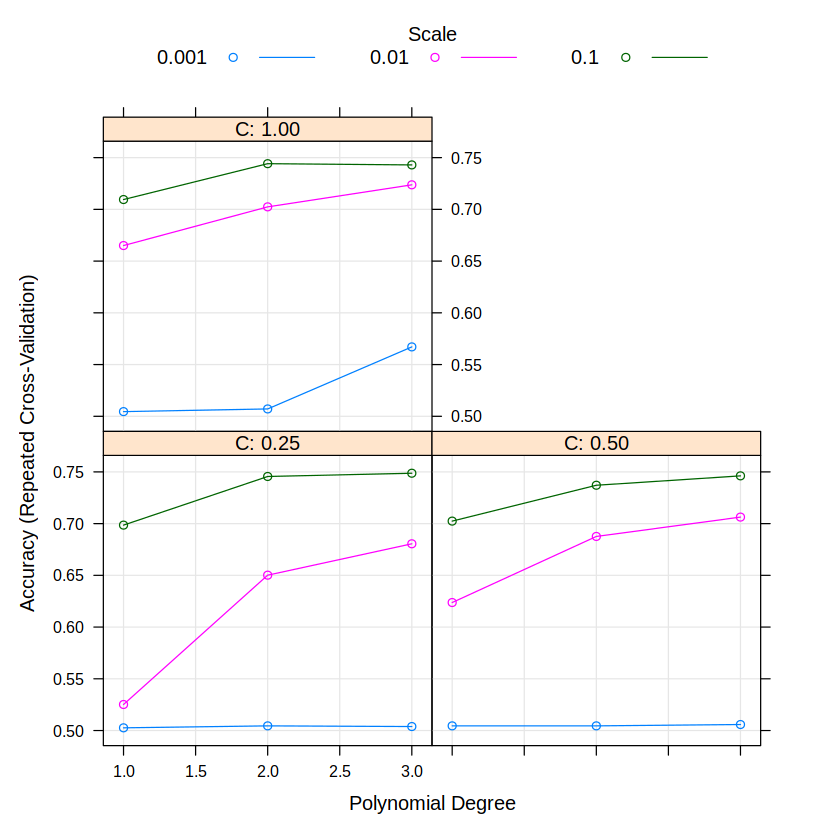

In [60]:
svmp.model
plot(svmp.model)


##### Radial Kernel


In [61]:
set.seed(seed)
svmr.model <- train(df.train.X, df.train.Y, method = "svmRadial", trControl = cv)
svmr.train.yPred <- predict(svmr.model, df.train.X)
svmr.test.yPred <- predict(svmr.model, df.test.X)

svmr.train.cm <- confusionMatrix(svmr.train.yPred, df.train.Y)
svmr.test.cm <- confusionMatrix(svmr.test.yPred, df.test.Y)
train.Res <- c(train.Res, svmr = svmr.train.cm$overall["AccuracyLower"])
test.Res <- c(test.Res, svmr = svmr.test.cm$overall["AccuracyLower"])


In [62]:
print("Support Vector Machine Polynomial Radial training set Accuracy")
svmr.train.cm$overall["AccuracyLower"]

print("Support Vector Machine Polynomial Radial testing set Accuracy")
svmr.test.cm$overall["AccuracyLower"]


[1] "Support Vector Machine Polynomial Radial training set Accuracy"


AccuracyLower 
     0.776817

[1] "Support Vector Machine Polynomial Radial testing set Accuracy"


AccuracyLower 
    0.6991615

Support Vector Machines with Radial Basis Function Kernel 

1552 samples
  27 predictor
   7 classes: 'Bumps', 'Dirtiness', 'K_Scatch', 'Other_Faults', 'Pastry', 'Stains', 'Z_Scratch' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 1397, 1395, 1395, 1397, 1398, 1398, ... 
Resampling results across tuning parameters:

  C     Accuracy   Kappa    
  0.25  0.7069652  0.6097298
  0.50  0.7236611  0.6367780
  1.00  0.7449312  0.6691088

Tuning parameter 'sigma' was held constant at a value of 0.03376161
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were sigma = 0.03376161 and C = 1.

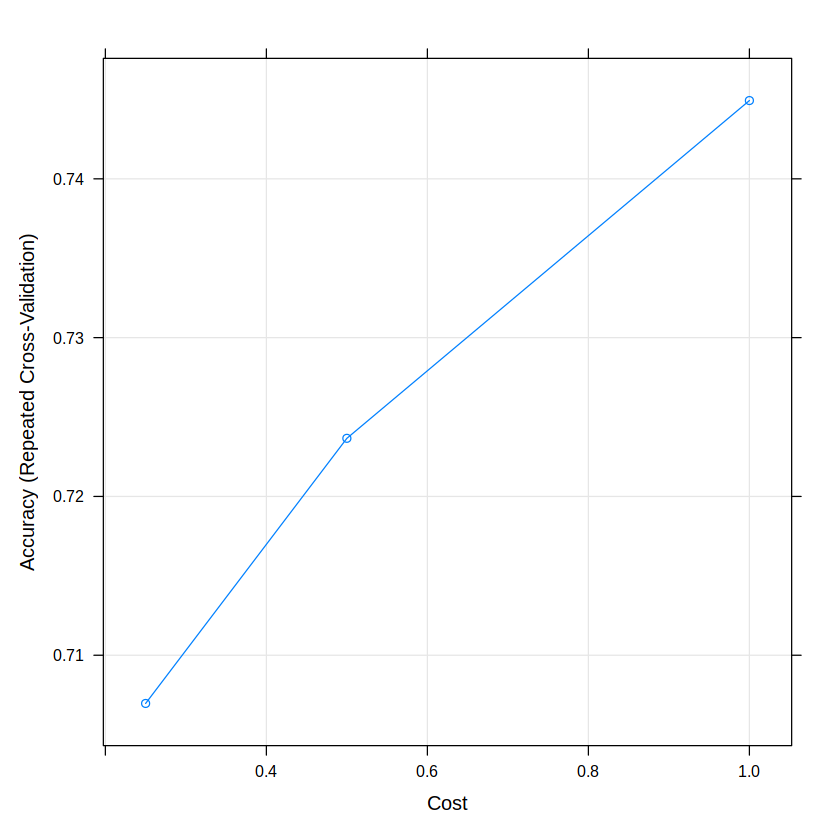

In [63]:
svmr.model
plot(svmr.model)


##### Confusion Matrix Heat map and Area under Curve (Best model by Accuracy without PCA)


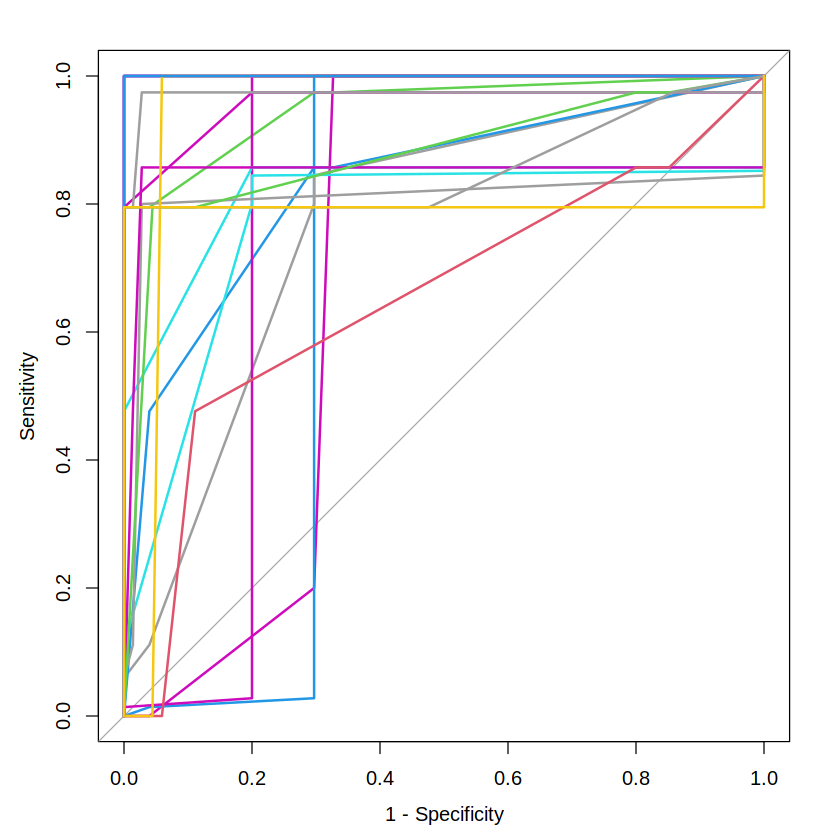

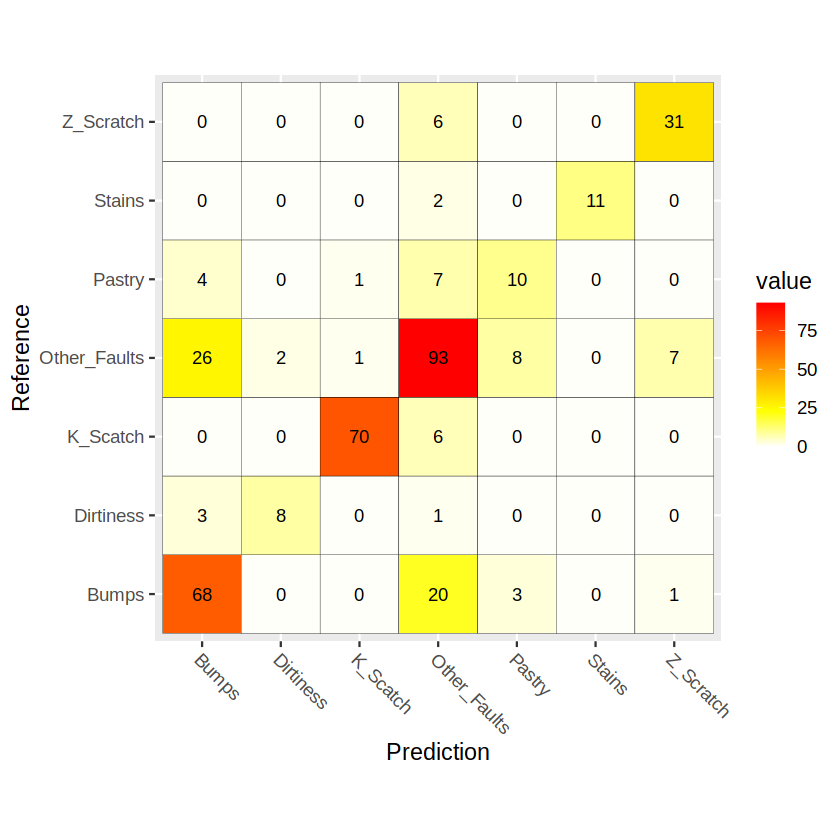

In [64]:
plotMultiRoc(svmp.test.yPred, as.numeric(df.test.Y), "<")
plotCM2Heatmap(svmp.test.cm$table)


## Conclusion


### Hightest Lower Accuracy by training set with PCA


In [65]:
train.PcaRes <- data.frame(train.PcaRes)
train.PcaRes[which(train.PcaRes == max(train.PcaRes))]


mlg.AccuracyLower,rf.AccuracyLower,bst.AccuracyLower,svml.AccuracyLower,svmp.AccuracyLower
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.997626,0.997626,0.997626,0.997626,0.997626


### Hightest Lower Accuracy by testing set with PCA


In [66]:
test.PcaRes <- data.frame(test.PcaRes)
test.PcaRes[which(test.PcaRes == max(test.PcaRes))]


bst.AccuracyLower,svml.AccuracyLower,svmp.AccuracyLower
<dbl>,<dbl>,<dbl>
0.9905618,0.9905618,0.9905618


### Hightest Lower Accuracy by training set


In [67]:
train.Res <- data.frame(train.Res)
train.Res[which(train.Res == max(train.Res))]



knn.AccuracyLower,rf.AccuracyLower
<dbl>,<dbl>
0.997626,0.997626


### Hightest Lower Accuracy by testing set


In [68]:
test.Res <- data.frame(test.Res)
test.Res[which(test.Res == max(test.Res))]



rf.AccuracyLower
<dbl>
0.7370747
